# Part 3 - Regression for Joint Angles

### 1. Visualize, Preprocess and Split the Data

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat
from scipy.ndimage import convolve1d
import seaborn as sns
import os
import sys
from pathlib import Path
from sklearn.preprocessing import StandardScaler

from scipy.io import loadmat 
from scipy.ndimage import convolve1d
from scipy.signal import butter
from scipy.signal import sosfiltfilt
from scipy.signal import welch

# Set root directory
root = Path(os.getcwd()).resolve().parent
if str(root).endswith('nssp-mp2'):
    os.chdir(root)
    sys.path.append(str(root))

data = loadmat('data/DB8/s1/S1_E1_A1.mat')
sns.set_theme(style='whitegrid')

FS = 2000  # Sampling frequency

/opt/homebrew/Caskroom/miniconda/base/envs/nssp/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


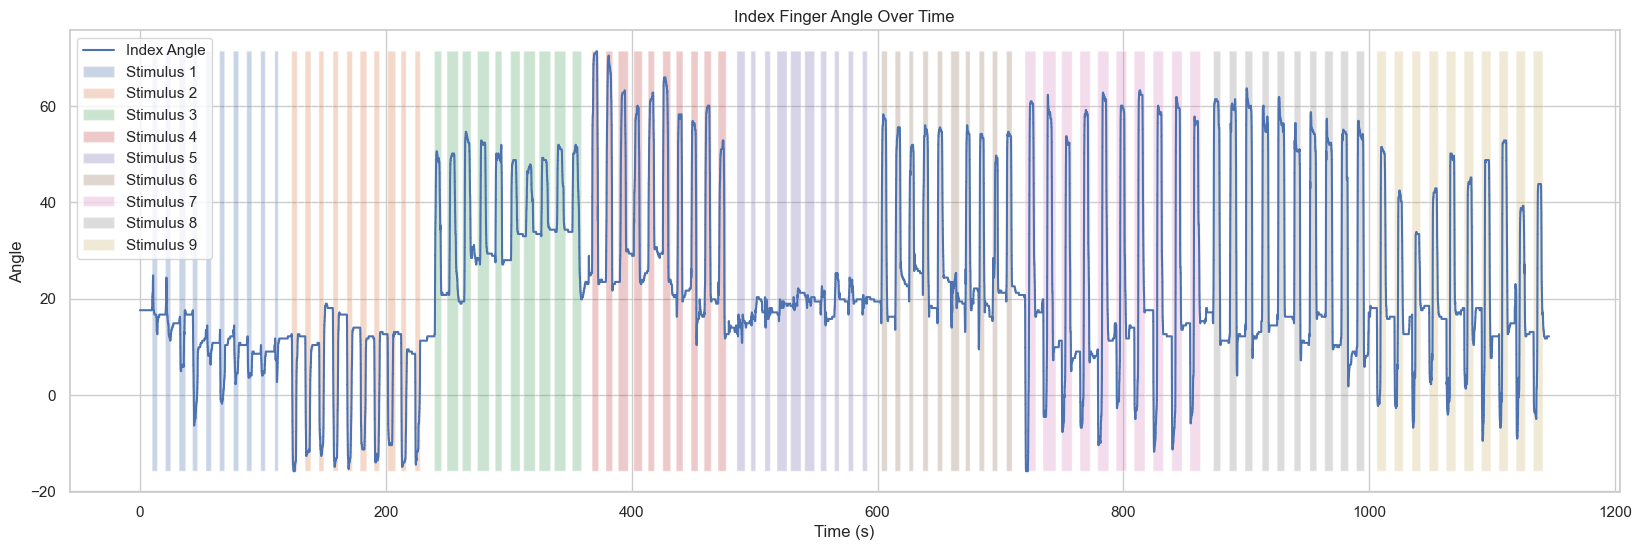

In [2]:
glove = data['glove']
restimulus = data['restimulus'].flatten()

finger_map = {
    'thumb': 3,
    'index': 6,
    'middle': 8,
    'ring': 11,
    'little': 14
}

def plot_finger_angles(glove, restimulus, finger_name: str):
    finger_idx = finger_map[finger_name]
    angles = glove[:, finger_idx]
    time = np.arange(len(angles)) / FS

    ang_min = angles.min()
    ang_max = angles.max()

    plt.figure(figsize=(20, 6))
    plt.plot(time, angles, label=f'{finger_name.capitalize()} Angle', linewidth=1.5)

    unique_states = np.unique(restimulus)
    for state in unique_states:
        if state == 0:
            continue
        mask = restimulus == state

        plt.fill_between(
            time,
            ang_min, ang_max,
            where=mask,
            step=None,
            alpha=0.3,
            label=f'Stimulus {state}'
        )

    plt.xlabel("Time (s)")
    plt.ylabel("Angle")
    plt.title(f"{finger_name.capitalize()} Finger Angle Over Time")
    plt.legend()
    plt.show()

plot_finger_angles(glove, restimulus, 'index')

In [3]:
emg = data['emg']

# 1. Apply rectification to the EMG signals by using np.abs
emg = np.abs(emg)

# 2. Apply a moving average filter to obtain the EMG envelopes
# Define moving average size
mov_mean_size = 400
# Based on the size, create the moving average weights to then convolve to the signal
mov_mean_weights = np.ones(mov_mean_size) / mov_mean_size
# Convolve the EMG signal with the moving average vectors along axis 0 (time axis)
emg_envelope = convolve1d(emg, mov_mean_weights, axis=0)

In [4]:
def extract_time_windows_regression(
        emg: np.ndarray, 
        labels: np.ndarray, 
        fs: int, 
        win_len: int, 
        step: int
    ) -> tuple:
    """
    This function is defined to perform an overlapping sliding window 
    Args:
        emg: Numpy array containing the data
        labels: Numpy array containing the targets
        fs: the sampling frequency of the signal
        win_len: The size of the windows (in seconds)
        step: The step size between windows (in seconds)

    Returns:
        emg_windows: A Numpy array containing the windows
        labels_windows: A Numpy array containing the targets aligned for each window
        
    The lengths of both outputs are the same (number of windows)
    """
    
    time_steps, channels = emg.shape

    # Convert win_len and step from seconds to samples
    win_len = int(win_len * fs)
    step = int(step * fs)

    start_points = np.arange(
        0,                              # Start at the beginning of the signal
        time_steps-win_len,             # End so that there are enough samples for a full window
        step=step                       # Step size in samples
    )

    # Calculate the end points of each window, given the start points and the window length
    end_points = start_points + win_len

    # Create a zero matrix for storing the EMG windows
    # shape (number of windows, length of each window, number of channels)
    emg_windows = np.zeros(shape = (len(start_points), win_len, channels))

    # Create another zero matrix for storing the labels windows
    label_windows = np.zeros(shape = (len(start_points), win_len, labels.shape[1]))

    # Iterate over the start points and extract the windows
    for i in range(len(start_points)):
        emg_windows[i,:,:] = emg[start_points[i]:end_points[i],:]
        label_windows[i,:,:] = labels[start_points[i]:end_points[i],:]

    return emg_windows, label_windows

In [5]:
# Extract finger data, selecting only the columns
finger_data = glove[:, [el for el in finger_map.values()]]  # (n_times, n_angles)

# Define window length and step in seconds
win_len = 50e-3  # 50 ms
step = 10e-3     # 10 ms

emg_windows, finger_windows = extract_time_windows_regression(
    emg=emg_envelope,
    labels=finger_data,
    fs=FS,
    win_len=win_len,
    step=step
)

In [15]:
from sklearn.model_selection import train_test_split

# Split the data into training, validation, and test sets
X_temp, X_test, y_temp, y_test = train_test_split(
    emg_windows, finger_windows, test_size=0.2, random_state=42
)

X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.25, random_state=42
)

print(f"EMG train data shape: {X_train.shape}, Train label shape: {y_train.shape}")
print(f"EMG validation data shape: {X_val.shape}, Train label shape: {y_val.shape}")
print(f"EMG test data shape: {X_test.shape}, Test label shape: {y_test.shape}")

EMG train data shape: (68772, 100, 16), Train label shape: (68772, 100, 5)
EMG validation data shape: (22925, 100, 16), Train label shape: (22925, 100, 5)
EMG test data shape: (22925, 100, 16), Test label shape: (22925, 100, 5)


### 2. Perform Sliding Window on the Data

### 3. Extract Features, Normalize them and Visualize Correlation Matrix

In [11]:
def extract_features(
        emg_windows: np.ndarray, 
        label_windows: np.ndarray,
        features: list = None
    ) -> tuple:
    """
    This function is defined to extract the features of each window
    Args:
        emg_windows: A Numpy array containing the windows
        label_windows: A Numpy array containing the labels windows
        features: A list of functions to extract features from each window
    Returns:
        emg_features: A Numpy array containing the mean, the standard deviation and the maximum amplitude of each window and the mean of the labels window
        labels_mean: A Numpy array containing the mean of the labels for each window
    """
    if features is None:
        raise ValueError("Please provide a list of functions to extract features.")

    # Initialize lists to hold features
    all_features = []
    for func in features:
        if not callable(func):
            raise ValueError("All elements in the functions list must be callable.")
        
        # Apply the function to each window and store the result
        feature_values = func(emg_windows, axis=1)
        all_features.append(feature_values)

    # Compute the mean of the labels for each window
    labels_mean = np.mean(label_windows, axis=1)

    # Concatenate the features for each window
    emg_features = np.concatenate(all_features, axis=1)

    return emg_features, labels_mean

In [18]:
features = [np.mean, np.std, np.max, np.min]

X_train_features, labels_train = extract_features(emg_windows=X_train, label_windows=y_train, features=features)
X_val_features, labels_val = extract_features(emg_windows=X_val, label_windows=y_val, features=features)
X_test_features, labels_test = extract_features(emg_windows=X_test, label_windows=y_test, features=features)

print("EMG train extracted features shape: {}, Finger feature shape: {}".format(X_train_features.shape, labels_train.shape))
print("EMG validation extracted features shape: {}, Finger feature shape: {}".format(X_val_features.shape, labels_val.shape))
print("EMG test extracted features shape: {}, Finger feature shape: {}".format(X_test_features.shape, labels_test.shape))

EMG train extracted features shape: (68772, 64), Finger feature shape: (68772, 5)
EMG validation extracted features shape: (22925, 64), Finger feature shape: (22925, 5)
EMG test extracted features shape: (22925, 64), Finger feature shape: (22925, 5)


Normalize features and compute correlation

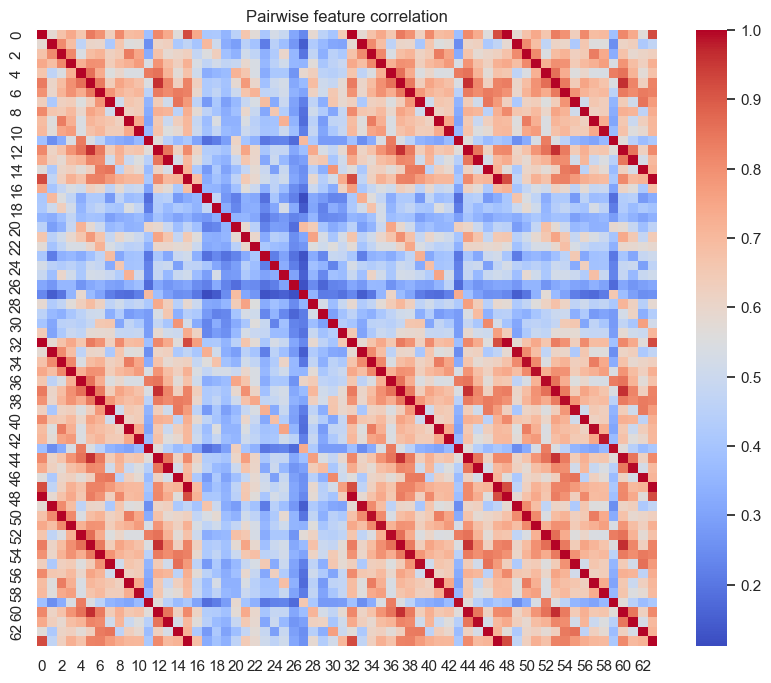

In [29]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

scaler = StandardScaler()
X_train_normalized = scaler.fit_transform(X_train_features)
X_val_normalized = scaler.fit_transform(X_val_features)
X_test_normalized = scaler.fit_transform(X_test_features)

corr_matrix = np.corrcoef(X_train_normalized, rowvar=False)
plt.figure(figsize=(10,8))
sns.heatmap(corr_matrix, cmap='coolwarm', fmt='.2f')
plt.title("Pairwise feature correlation")
plt.show()

### 4. Perform Regression on the Kinematics

Linear regression

In [33]:
#Fit and predict using the linear regression model
from sklearn.linear_model import LinearRegression

model = LinearRegression()
model.fit(X_train_normalized, labels_train)
labels_predicted = model.predict(X_test_normalized)

Random forest

In [ ]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train_normalized, labels_train)
labels_rf_predicted = rf.predict(X_test_normalized)

### 5. Evaluate the Performance

In [ ]:
from sklearn.metrics import mean_squared_error

# Compute the mean squared error
MSE_linear = mean_squared_error(labels_test, labels_predicted)
MSE_rf = mean_squared_error(labels_test, labels_rf_predicted)

print(f'MSE of Linear Regression: {MSE_linear}')
print(f'MSE of Random Forest: {MSE_rf}')

MSE of Linear Regression: 54.372626343180556


### 6. Assess stability of the results across different Finger Angles